# Required packages
Please make sure you have ggplot2 and dplyr installed. To do so, go into R and enter the following command: <br>
`install.packages(c('ggplot2','dplyr'))` <br>
This can also be done using Anaconda: <br>
`conda install -c r r-dplyr` <br>
`conda install -c r r-ggplot2 
`

# Load [IBD GWAS summary stats](ftp://ftp.sanger.ac.uk/pub/consortia/ibdgenetics/iibdgc-trans-ancestry-filtered-summary-stats.tgz)

We will be working with GWAS summary statistics from the [International Inflammatory Bowel Disease Genetics Consortium (IIBDGC)](https://www.ibdgenetics.org/about.html). There are two main types of inflammatory bowel disease (IBD): Crohn's disease (CD) and ulcerative colitis (UC). <br> 

### Associated references
1. Liu, J.Z., van Sommeren, S., Huang, H., Ng, S.C., Alberts, R., Takahashi, A., Ripke, S., Lee, J.C., Jostins, L., Shah, T. and Abedian, S., 2015. Association analyses identify 38 susceptibility loci for inflammatory bowel disease and highlight shared genetic risk across populations. Nature genetics, 47(9), pp.979-986. Vancouver
2. Goyette, P., Boucher, G., Mallon, D., Ellinghaus, E., Jostins, L., Huang, H., Ripke, S., Gusareva, E.S., Annese, V., Hauser, S.L. and Oksenberg, J.R., 2015. High-density mapping of the MHC identifies a shared role for HLA-DRB1 [ast] 01: 03 in inflammatory bowel diseases and heterozygous advantage in ulcerative colitis. Nature genetics, 47(2), pp.172-179. Vancouver

We will be working with a thinned dataset (1% of rows randomly selected) for practicality. 

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))

In [2]:
ibd <- read.table('IBD_GWAS_summary_thinned.txt',header=TRUE)

In [3]:
head(ibd)

CHR,SNP,BP,A1,A2,FRQ_A_12882,FRQ_U_21770,INFO,OR,SE,P,Direction,HetISqt,HetPVa,nstudies,studies_included
11,rs1893630,58598691,T,C,0.0218,0.0207,0.962,1.06844,0.0595,0.2658,-+++++++++---+-,-11.8,0.42680,15,15
16,rs6497696,23901896,T,C,0.9460,0.9440,0.974,0.99661,0.0369,0.9263,+-+---+-+++---+,-2.8,0.34090,15,15
4,rs142699136,75837642,C,G,0.4140,0.4190,0.898,0.98373,0.0180,0.3629,-+++--+-+-+-++-,18.1,0.14530,15,15
2,rs10199426,45961154,C,G,0.9200,0.9230,0.968,0.97307,0.0313,0.3835,----+--++-++--+,0.0,0.86980,15,15
20,rs142435456,14653907,A,C,0.9830,0.9820,0.563,1.04991,0.0849,0.5662,-+++++----++-+-,40.2,0.02082,15,15
4,rs74924571,56679171,A,G,0.9920,0.9930,0.924,1.09900,0.1472,0.5216,????++?--?++??-,2.6,0.22270,15,7


To start, let's a take a look at the distribution of p-values for the SNPs in the summary statistics:

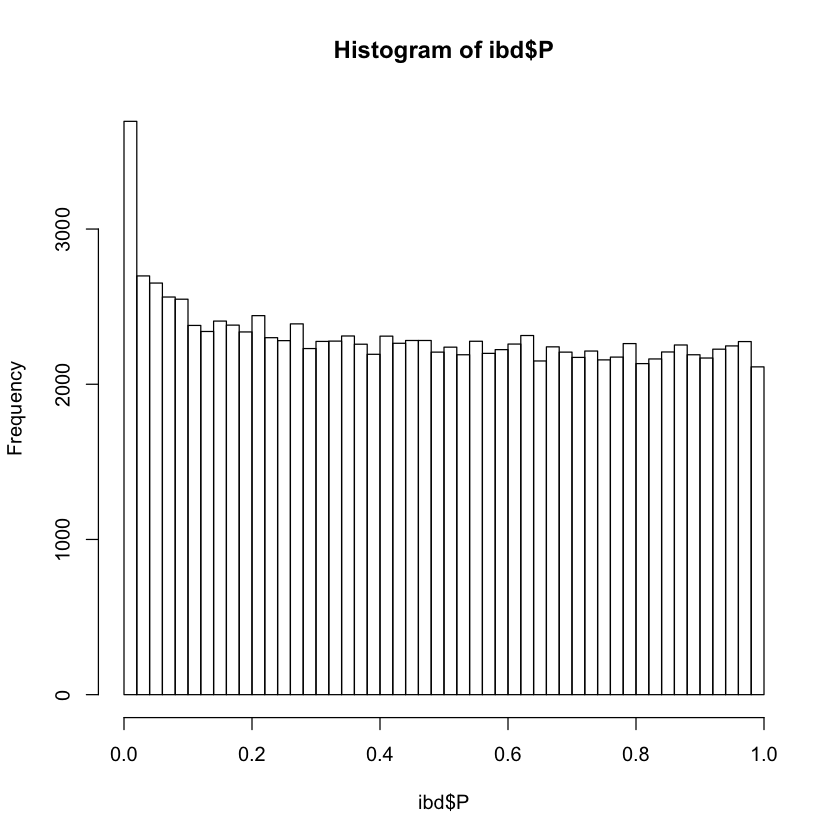

In [8]:
hist(ibd$P, breaks=50)

Though the distribution is fairly uniform, there's a relatively large number of SNPs with low (significant) p-values! We can get a better idea understanding of what's going on with the lower tail with a qq-plot, which reflects the deviation of a distribution from the null expected distribution. <br>

"The quantile-quantile (qq) plot is a graphical technique for determining if two data sets come from populations with a common distribution.
A qq plot is a plot of the quantiles of the first data set against the quantiles of the second data set. By a quantile, we mean the fraction (or percent) of points below the given value. That is, the 0.3 (or 30%) quantile is the point at which 30% percent of the data fall below and 70% fall above that value.

A 45-degree reference line is also plotted. If the two sets come from a population with the same distribution, the points should fall approximately along this reference line. The greater the departure from this reference line, the greater the evidence for the conclusion that the two data sets have come from populations with different distributions."

The advantages of the q-q plot are:

1. The sample sizes do not need to be equal.
1. Many distributional aspects can be simultaneously tested. For example, shifts in location, shifts in scale, changes in symmetry, and the presence of outliers can all be detected from this plot. For example, if the two data sets come from populations whose distributions differ only by a shift in location, the points should lie along a straight line that is displaced either up or down from the 45-degree reference line.

([source](https://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm))

# Plot QQ-plot

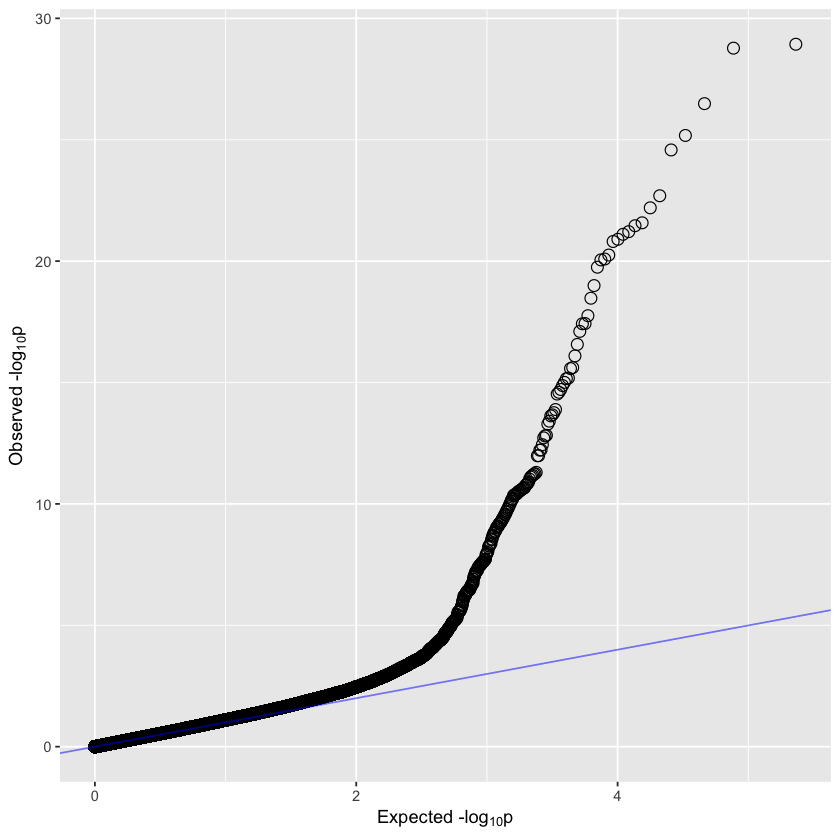

In [25]:
qq_df <- data.frame(observed=-log10(sort(ibd$P)),expected=-log10(ppoints(length(ibd$P))))

log10Pe <- expression(paste("Expected -log"[10], "p"))
log10Po <- expression(paste("Observed -log"[10], "p"))

ggplot(qq_df) + 
    geom_point(aes(expected, observed), shape = 1, size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5, color='blue') +
    xlab(log10Pe) + ylab(log10Po)

Here, we use $-\log_{10} p$. SNPs with large $p$ have smaller $-\log_{10}p$, and they appear to largely follow the null expected (the diagonal line). They quickly began to deviate from the null distribution as $p$ gets smaller ($-\log_{10}p$ gets larger) and more significant. Thus, we have high confidence that there are genetic loci with strong statistical associations with IBD.

Next, let's visualize the GWAS results.

# Manhattan plot
## 1. Calculate cumulative position of each SNP

In [14]:
plt_data <- ibd %>% 
  
  # Compute chromosome size
  group_by(CHR) %>% 
  summarise(chr_len=max(BP)) %>% # get largest BP value for each chr; makes chr_len column
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>% # makes tot column
  select(-chr_len) %>% # remove chr_len column; tot column remains
  
  # Add this info to the initial dataset
  left_join(ibd, ., by=c("CHR"="CHR")) %>% # add tot column by matching to chromosome
  
  # Add a cumulative position of each SNP
  arrange(CHR, BP) %>% #arrange by bp
  mutate( BPcum=BP+tot) #add BPcum column

In [15]:
head(plt_data)

CHR,SNP,BP,A1,A2,FRQ_A_12882,FRQ_U_21770,INFO,OR,SE,P,Direction,HetISqt,HetPVa,nstudies,studies_included,tot,BPcum
1,rs192687139,523471,T,C,0.84200,0.84000,0.304,1.03138,0.0415,0.4571,-+++++--++++++-,-7.5,0.3864,15,15,0,523471
1,chr1_697411_I,697411,I2,D,0.01730,0.01750,0.400,0.99154,0.0971,0.9302,+-+-+---+++--+-,0.0,0.6608,15,15,0,697411
1,rs115616822,773106,A,G,0.00822,0.00776,0.343,1.11472,0.1609,0.4996,-+-++++-++++-?-,0.0,0.8487,15,14,0,773106
1,rs7553096,802026,A,G,0.25000,0.24700,0.472,1.02768,0.0281,0.3315,++++-++---+++++,-5.2,0.3641,15,15,0,802026
1,rs113736132,811381,T,C,0.05810,0.05650,0.322,1.09494,0.0634,0.1529,++--+++++++--++,21.9,0.1158,15,15,0,811381
1,rs143725925,811630,A,G,0.26000,0.26000,0.343,1.01593,0.0325,0.6275,+++++--++-+++--,12.6,0.1934,15,15,0,811630


## 2. Prepare x-axis

In [16]:
# give location of axis tick for chromosome centered on window for each chr
axisdf <- plt_data %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

## 3. Plot

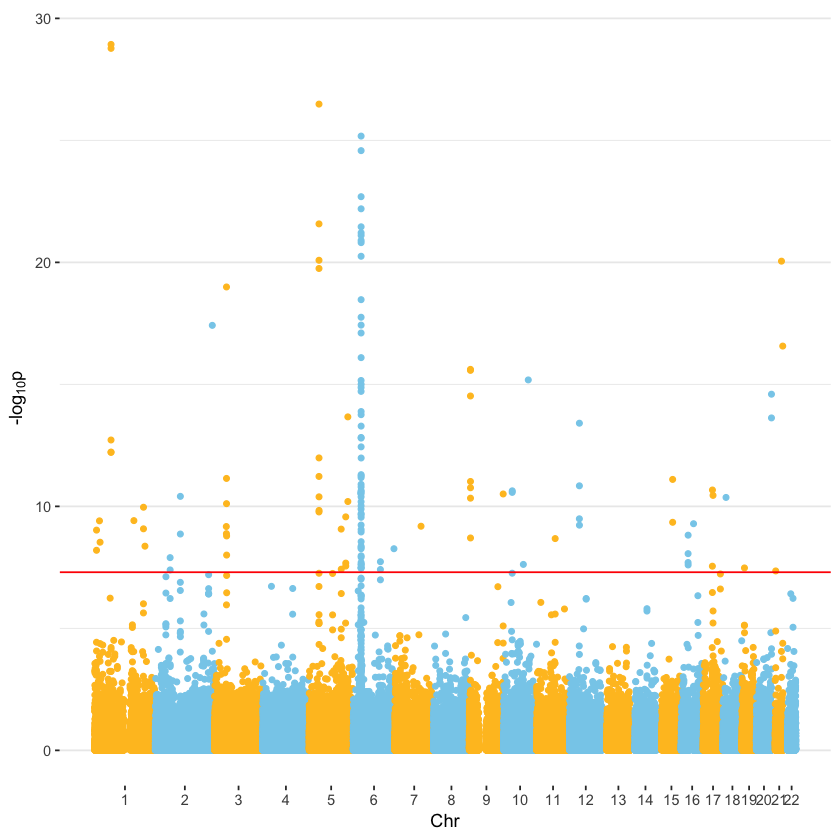

In [27]:
ggplot(plt_data, aes(x=BPcum, y=-log10(P))) +
    
    # Show all points
    geom_point( aes(color=as.factor(CHR)), size=1.3) +
    scale_color_manual(values = rep(c("goldenrod1", "skyblue"), 22 )) +
    
    # custom X axis:
    scale_x_continuous( label = axisdf$CHR, breaks= axisdf$center ) +
    #scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis
  
    # Custom theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()) +

    # Add line for genome-wide significance
    geom_hline(yintercept = -log10(5*10^-8), color='red') + 
    # Rename x-axis
    labs(x='Chr',y=expression(paste("-log"[10], "p")))

We added a red line to denote where $p=10^{-8}$. This is the widely-used __genome-wide significance__ threshold. Points which fall above the red line in the Manhattan plot have genome-wide signficance! It looks like there's a very defined peak of genome-wide significant SNPs localized on chromosome 6. Let's take a closer look. <br>

*By the way, why do you think Manhattan plots have so many peaks like this one?*

In [41]:
chr6_gws <- ibd %>% filter(CHR == 6, P < 10^(-8))
sprintf("# of genome-wide significant SNPs in (thinned) IBD GWAS: %d", dim(chr6_gws)[1])

[1] "# of genome-wide significant SNPs in (thinned) IBD GWAS: 50"

[1]  31248863  32359150  32370835  32379489  32441178  32445600  32449257
 [8]  32452626  32457258  32457844  32460549  32471679  32506894  32509050
[15]  32510208  32510827  32517043  32519018  32525044  32536340  32537317
[22]  32537782  32537950  32568382  32569852  32570311  32572202  32572975
[29]  32573713  32573754  32573895  32585762  32588435  32598853  32605738
[36]  32607416  32612807  32612934  32629297  32629889  32630794  32631954
[43]  32633091  32633398  32636443  32639737  32646616  32659332  32743835
[50] 167386104

What are the positions of the genome-wide significant SNPs on chr6?

In [42]:
sort(chr6_gws$BP)

[1]  31248863  32359150  32370835  32379489  32441178  32445600  32449257
 [8]  32452626  32457258  32457844  32460549  32471679  32506894  32509050
[15]  32510208  32510827  32517043  32519018  32525044  32536340  32537317
[22]  32537782  32537950  32568382  32569852  32570311  32572202  32572975
[29]  32573713  32573754  32573895  32585762  32588435  32598853  32605738
[36]  32607416  32612807  32612934  32629297  32629889  32630794  32631954
[43]  32633091  32633398  32636443  32639737  32646616  32659332  32743835
[50] 167386104

Let's take a closer look at what that region is: <br>
<img src="mhc_genome_browser_hg19.png">

What's so special about this region? There is a high density of __human leukocyte antigen (HLA)__ genes here - these encode the __major histocompatibility complex (MHC)__ proteins in humans. These proteins are essential for the immune system to recognize foreign molecules. It is a very polygenic region, as diversity of antigen presentation is advantageous for the effectiveness of the immune system for targeting foreign invaders. This corroborates the findings of the paper based on this GWAS data (Goyette P., et al. Nature 2015). The MHC region is often implicated in autoimmune like IBD, and many other complex diseases. You can read more [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5406920/) if you're interested.